In [2]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib as mpl
from scipy import signal
from matplotlib import pyplot as plt
import datain
import time
import seaborn as sns

%reload_ext autoreload
%autoreload 2

In [3]:
def decimate(data,tarr=np.array([]), decfac=1):
    reshaped=data.reshape(int(data.size/decfac),decfac)
    decimated=np.mean(reshaped,axis=1)
#     print('dec',np.isnan(decimated))
#     print('resh',np.isnan(reshaped))

    if tarr.size>0:
        tarre=tarr[::decfac]
        del data, tarr
        return decimated, tarre
    else:
        del data
        return decimated

def sigavg(data, freq,tarr=np.array([]), sampf=50000, cycle=1, decfac=1):
    tf=data.size/sampf
    wfm=tf*freq
    wfmck=np.remainder(wfm,cycle)
    if wfmck>0.0:
        return 'Data not integer cycles'
    else:
        datare=data.reshape(int(wfm),int(sampf/freq))
        datavg=np.mean(datare,axis=0)
    if tarr.size>0:
        tarre=tarr[:int(sampf/freq)]
        del data, tarr
        return datavg, tarre
    else:
        del data
        return datavg
    
def getfft(data, tarr=np.array([])):
    datafft=np.zeros(np.shape(data))+1j*0
    Ns=np.shape(data)[1]
    
    if tarr.size>0:
        dt=tarr[1]
        freq=np.fft.fftshift(np.fft.fftfreq(Ns,dt))
        datafft=np.fft.fftshift(np.fft.fft(data,axis=1)/(Ns/2),axes=1)#Ns)
        del data, tarr
        return datafft, freq
    else:
        datafft=np.fft.fftshift(np.fft.fft(data)/(Ns/2))#Ns)
        del data
        return datafft
    
def submean(data):
    datare=data-np.mean(data)
    del data
    return datare

def colorfun(V,Max=1):
    if V>0:
        R=V/Max
        G=0
        B=0
    else:
        R=0
        G=0
        B=-V/Max
    return (R,G,B)

In [95]:
def fullanalyze(data, fa, dec, PhsCor="VPhs",Rohm=63.97):
    #Reads data, subtracts mean from current (J) and voltage (V) signals but not from X-ray ratio (Ir)
    #Adjusts phase of all signals to mimic a sine wave
    #Decimates by a factor "dec" to reduce sampling rate (e.g. 5000 samples becomes 50 with dec=100)
    #Signal averages down to one period of frequency = fa after decimating signal

    Ir=np.array(data['If']/data['Io'])
    
    #Finds any infinite number from calculating Ir and makes selection array 
#     delarr=np.isfinite(Ir)
#     Ir=Ir[delarr]
    
    Imean=np.mean(Ir)
    Iomean=np.mean(data['Io'])
    Ifmean=np.mean(data['If'])
    datan=np.array([data['Time'],submean(Ir),submean(data['J']),submean(data['V']),
                    submean(data['Io']),submean(data['If'])])

    if PhsCor=="EtaPhs":
        Rohm=63.97
        eta=datan[3,:,None]-datan[2,:,None]*Rohm/100
        datan=np.concatenate((datan,eta.T),axis=0)
        
        
    Ns=datan[0,:].size
    dt=datan[0,1]

    datafft, freq=getfft(datan[1:,:],datan[0,:])
    fftang=np.angle(datafft)
    fftmag=np.abs(datafft)
    bin1=datain.fftbin(fa,freq,Ns,dt,"Real",1)
    bina=int(bin1[1])
    
    
        
    angadj=fftang[2,int(bin1[1])]+np.pi/2 #Voltage phase correction
    angadj2=fftang[0,int(bin1[1])]+np.pi/2 #Ir phase correction
    angadj3=fftang[1,int(bin1[1])]+np.pi/2 #J phase correction
    
    if PhsCor=="EtaPhs":
        angadj4=fftang[5,int(bin1[1])]+np.pi/2 #Eta phase correction

    fftang2=fftang.copy()

    
    if PhsCor=="Vphs":
        fftang2[:,int(Ns/2):]=fftang[:,int(Ns/2):]-angadj #adjusting positive frequencies
        fftang2[:,:int(Ns/2)]=fftang[:,:int(Ns/2)]+angadj #adjusting negative frequencies
    elif PhsCor=="IndivPhs":
        fftang2[0,int(Ns/2):]=fftang[0,int(Ns/2):]-angadj2 #adjusting positive frequencies for Ir
        fftang2[0,:int(Ns/2)]=fftang[0,:int(Ns/2)]+angadj2 #adjusting negative frequencies for Ir
        fftang2[3:5,int(Ns/2):]=fftang[3:5,int(Ns/2):]-angadj2 #adjusting positive frequencies for Io and If
        fftang2[3:5,:int(Ns/2)]=fftang[3:5,:int(Ns/2)]+angadj2 #adjusting negative frequencies for Io and If
        fftang2[2,int(Ns/2):]=fftang[2,int(Ns/2):]-angadj #adjusting positive frequencies for V
        fftang2[2,:int(Ns/2)]=fftang[2,:int(Ns/2)]+angadj #adjusting negative frequencies for V
        fftang2[1,int(Ns/2):]=fftang[1,int(Ns/2):]-angadj3 #adjusting positive frequencies for J
        fftang2[1,:int(Ns/2)]=fftang[1,:int(Ns/2)]+angadj3 #adjusting negative frequencies for J
    elif PhsCor=="EtaPhs":
        fftang2[:,int(Ns/2):]=fftang[:,int(Ns/2):]-angadj4 #adjusting positive frequencies
        fftang2[:,:int(Ns/2)]=fftang[:,:int(Ns/2)]+angadj4 #adjusting negative frequencies
    else:
        print(PhsCor+ ' is an invalid selection for PhsCor variable.')
        return
        
        
    datafft2=datain.P2R(fftmag,fftang2)

    dataffti=np.fft.ifft(np.fft.ifftshift(datafft2,axes=1)*Ns/2)

    t=datan[0,:]
    Ir=dataffti[0,:]
    V=dataffti[1,:]
    J=dataffti[2,:]
    Io=dataffti[3,:]
    If=dataffti[4,:]
    Et=dataffti[5,:]

    # fa=0.5
    # dec=2000
    fs=50000

    Irdec,tdec=decimate(Ir,tarr=t,decfac=dec)
    Iav,tav=sigavg(Irdec, freq=fa,tarr=tdec,sampf=fs/dec,decfac=dec)
    Vav=sigavg(decimate(V,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)
    Jav=sigavg(decimate(J,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)
    Ioav=sigavg(decimate(Io,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)
    Ifav=sigavg(decimate(If,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)
    Etav=sigavg(decimate(Et,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)
    
#     print(angadj)#,angadj2,angadj3)
#     print(fftang2[0,(bina-2):(bina+2)],fftang2[1,bina-2:bina+2],fftang2[2,bina-2:bina+2])
#     print(fftang2[0,int(bin1[1])],fftang2[1,int(bin1[1])],fftang2[2,int(bin1[1])])
    Iav=Iav+Imean
    Ioav=Ioav+Iomean
    Ifav=Ifav+Ifmean
    
    datav=np.array([[tav,Iav,Vav,Jav,Ioav,Ifav,Etav]])
    del data
    return datav


def partanalyze(data, fa, dec):
    #Reads data, subtracts mean from current (J) and voltage (V) signals but not from X-ray ratio (Ir)
    #Decimates by a factor "dec" to reduce sampling rate (e.g. 5000 samples becomes 50 with dec=100)
    #Signal averages down to one period of frequency = fa after decimating signal
    
    Ir=np.array(data['If']/data['Io'])
    t=np.array(data['Time'])
    J=submean(np.array(data['J']))
    V=submean(np.array(data['V']))
    
    fs=50000
    
    Irdec,tdec=decimate(Ir,tarr=t,decfac=dec)
    Iav,tav=sigavg(Irdec, freq=fa,tarr=tdec,sampf=fs/dec,decfac=dec)
    Vav=sigavg(decimate(V,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)
    Jav=sigavg(decimate(J,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)
    
    datav=np.array([[tav,Iav,Vav,Jav]])
    del data
    return datav

def readolddata(path, decfac, fa,NumCh=4):
    fsamp=50000
    samplen=int(fsamp/(decfac*fa))

    data=np.genfromtxt(path, delimiter='  ', dtype=complex,autostrip=True)

    datdum=pd.DataFrame(data)
    datdum.dropna(inplace=True)
    data=np.array(datdum)
    dum2d=data.copy()
    
    numE=int(data.shape[0]/samplen)
    dum2d=dum2d.reshape(data.shape[0],int(dum2d.size/data.shape[0]))

    del data
    dum3d=dum2d.reshape([samplen,numE,NumCh]).transpose(1,2,0) 
    return dum3d

def SavebyVoltage(data,Energies,Estart,Efinish,directory,fHead,suff):
    
    for n in np.r_[0:data.shape[2]]:
        svname=directory+fHead+str(n)+"_"+str(int(np.round(np.real(data[0,3,n]),3)*1000))+"_mV "+suff
        print(svname)
        Edat=np.concatenate((data[:,:,n],Energies[Estart-1:Efinish,None]),axis=1)
        svdat=np.roll(Edat,1,axis=1)
        np.savetxt(svname, svdat,delimiter='\t',fmt='%.8e')
        
def plotXANES(Edata,data,start=0,stop=0,marker='.',in_adjs=[0,0,.1,0,0,.02,0,0],
             startE=7705,stopE=7730,startInE=7718,stopInE=7720,size=(9,6),UseEta=False):
    in_x1adj=in_adjs[0]
    in_x2adj=in_adjs[1]
    in_xint =in_adjs[2]
    in_y1adj=in_adjs[3]
    in_y2adj=in_adjs[4]
    in_yint =in_adjs[5]
    in_xlat=in_adjs[6]
    in_yvert =in_adjs[7]

    title_font = {'fontname':'Arial', 'size':'10', 'color':'black', 'weight':'normal'}
    mpl.rcParams['xtick.labelsize']=10
    mpl.rcParams['ytick.labelsize']=10
    mpl.rcParams['legend.fontsize']=10
    mpl.rcParams['axes.labelsize']=10

#     if UseEta==True:
#         data=CalcEta(data)
    
    AbsMax=np.max(data[:,1,0])
    AbsMin=np.round(np.real(data[np.argwhere(Edata[:,0]>=startE)[0][0],1,0]),2) #np.min(data[:,1,0])
    
    if UseEta==False:
        MaxV=int(round(np.max(data[0,3,:])*1000,0))
        MinV=int(round(np.min(data[0,3,:])*1000,0))
    else:
        MaxV=int(round(np.max(data[0,-1,:])*1000,0))
        MinV=int(round(np.min(data[0,-1,:])*1000,0))
    
    ## Plotting full RDF
    fig=plt.figure(constrained_layout=False,figsize=size)
    gs=fig.add_gridspec(5,20)
    f_ax1=fig.add_subplot(gs[:,:-1])
    for n in range(start,data.shape[2]-stop):
        if UseEta==False:
            f_ax1.plot(Edata[:,n],data[:,1,n].T,
                     color=(colorfun(data[0,3,n],np.max(np.abs(data[0,3,:])))),
                     linestyle='-',linewidth=.3,marker='',markersize=3,
                       label=str(str(data[n,3,0])+' mV'))
        else:
            f_ax1.plot(Edata[:,n],data[:,1,n].T,
                     color=(colorfun(data[0,-1,n],np.max(np.abs(data[0,-1,:])))),
                     linestyle='-',linewidth=.3,marker='',markersize=3)
                       #label=str(str(data[n,3,0])+' mV'))
    f_ax1.set(xlim=[startE,stopE],ylim=[.97*AbsMin,1.05*AbsMax])#,yticks=[])
    f_ax1.set_ylabel(r'Absorption  / a.u.',**title_font)
    f_ax1.set_xlabel(r'Energy  /  eV',**title_font)
    # ax1minLoc=mpl.ticker.MultipleLocator(.5)
    # f_ax1.xaxis.set_minor_locator(ax1minLoc)


    ## Plotting RDF inset
    f_ax2=fig.add_subplot(gs[0:3,3:11])    
    for n in range(start,data.shape[2]-stop):
        if UseEta==False:
            f_ax2.plot(Edata[:,n],data[:,1,n].T,
                     color=(colorfun(data[0,3,n],np.max(np.abs(data[0,3,:])))),
                     linestyle='-',linewidth=.5,marker=marker,markersize=3,
                       label=str(str(data[n,3,0])+' mV'))
        else:
            f_ax2.plot(Edata[:,n],data[:,1,n].T,
                     color=(colorfun(data[0,-1,n],np.max(np.abs(data[0,-1,:])))),
                     linestyle='-',linewidth=.5,marker=marker,markersize=3)
                       #label=str(str(data[n,3,0])+' mV'))
    f_ax2.set(xlim=[startInE,stopInE])

    ## Choosing plot limits for inset

    xind1=np.argwhere(Edata[:,0]>=startInE)[0]
    xind2=np.argwhere(Edata[:,0]<=stopInE)[-1]

    x1=round(Edata[xind1,0][0])
    x2=round(Edata[xind2,0][0])

    y1=round(data[xind1,1,0][0]*.95,2)
    y2=round(data[xind2,1,0][0]*1.05,2)


    f_ax2.set(xlim=[x1+in_x1adj,x2+in_x2adj], xticks=np.arange(x1+in_x1adj,x2+in_x2adj,in_xint),
              ylim=[y1+in_y1adj,y2+in_y2adj], yticks=np.arange(y1+in_y1adj,y2+in_y2adj,in_yint))

    f_ax2.set(xlim=[x1+in_xlat+in_x1adj,x2+in_xlat+in_x2adj], 
              xticks=np.arange(x1+in_x1adj,x2+in_x2adj,in_xint),
              ylim=[y1+in_yvert+in_y1adj,y2+in_yvert+in_y2adj], 
              yticks=np.arange(y1+in_y1adj,y2+in_y2adj,in_yint))

    #Plotting colorbar
    f_ax3=fig.add_subplot(gs[:3,-1])
    cdict = {'red':   [(0.0, 0.0, 0.0),
                               (0.5, 0.0, 0.0),
                               (1.0, 1.0, 1.0)],

                     'green': [(0.0, 0.0, 0.0),
                               (0.5, 0.0, 0.0),
                               (1.0, 0.0, 0.0)],

                     'blue':  [(0.0, 1.0, 1.0),
                               (0.5, 0.0, 0.0),
                               (1.0, 0.0, 0.0)],}

    cmap_name = 'my_list'
    cm = mpl.colors.LinearSegmentedColormap(cmap_name, cdict, N=100)
    norm = mpl.colors.Normalize(vmin=MinV, vmax=MaxV)
    cb1=mpl.colorbar.ColorbarBase(f_ax3, cmap=cm,norm=norm,orientation='vertical')
    cb1.set_ticks([MinV,0,MaxV])
    cb1.set_label('mV',rotation=0, labelpad=-3, verticalalignment='center')
    
    return fig

def CalcEta(data,Rohm=63.97,Zparams=[63.97,47.43,0.0066108,.932]):
    R1=Zparams[0]
    R2=Zparams[1]
    Q=Zparams[2]
    a=Zparams[3]
    
    freq=1/(data[0,0,-1]+data[0,0,1])
    
    V=data[0,3,:,None].T
    I=data[0,2,:,None].T
#     eta=np.real(V)*np.abs(R2/(R1*(1+(2*np.pi*freq*1j*Q)**a*R2)+R2))
    eta=V-I*Rohm
    data=np.concatenate((data,np.tile(eta,(data.shape[0],1,1))),axis=1)
    
    return data

In [97]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data'
# path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data\E90.txt'
# path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 5Hz test data'  #Dynamic XAS Energy Spectrum 0_5Hz test data'
initfile=82
finfile=89

fa=0.5
decfac=2000


filea=np.r_[initfile:finfile+1]
sttime=time.perf_counter()

for n in filea:
    filestr=str(path+'/E'+str(n)+'.txt')
    print(filestr)
    stloop=time.perf_counter()
    
    all_files=glob.glob(filestr)
    data=pd.read_csv(filestr,delimiter='\t', header=None,engine='python')
    data.columns=('Time','Io','If','J','V') #Io is incident X-ray, If is fluroesced X-ray
    print('Data read time:'+ str(time.perf_counter()-stloop))
    if n==filea[0]:
        dum1=fullanalyze(data, fa,decfac,PhsCor="EtaPhs")
        print(time.perf_counter()-stloop)
#         dum1=partanalyze(data,0.5,2000)
    else:
        dum1=np.concatenate((dum1,fullanalyze(data,fa,decfac,PhsCor="EtaPhs")),axis=0)
        print(time.perf_counter()-stloop)
#         dum1=dum1=np.concatenate((dum1,partanalyze(data,0.5,2000)),axis=0)

    
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist=pd.read_csv(path, header=None)
Elist=np.array(Elist[0])

Edum=np.tile(Elist,dum1.shape[2])
Edum.resize(dum1.shape[2],Elist.size)

dum2=dum1
dum2d=dum2.transpose(2,0,1).reshape(-1,dum2.shape[1])

print(dum2d.shape,time.perf_counter()-sttime)

C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E82.txt
Data read time:40.93766407387966
72.2777407078629
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E83.txt
Data read time:31.87216449718744
51.076621341288046
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E84.txt
Data read time:31.768835829528143
52.39579330868946
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E85.txt
Data read time:32.09464640634451
52.224716375644675
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E86.txt
Data read time:30.83592434260845
50.92502013824833
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E87.txt
Data read time:32.8433317412364
55.45022879972839
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E

In [5]:
np.savetxt('Dynamic XAS Energy analyzed data\ESweep5Hz_ReaddMean_PhsCorrect_RawXray_Dec200_Hold.txt', dum2d,fmt='%.8e')

In [ ]:
##### dumstor=dum2
dumstor2d=dum2d

In [ ]:
direc='Dynamic XAS Energy analyzed data\ESweep_0_5 Hz'
fiHead=
# SavebyVoltage(dum1,Elist,initfile,finfile,)

In [125]:
dum2=dum5stor.copy()
dum2d=dum2.transpose(2,0,1).reshape(-1,dum2.shape[1])
dum2d=np.real(dum2d)

In [122]:
Edum5=np.delete(Edum,6,axis=1)
np.savetxt('Energy List for 5 Hz.txt', Edum5[0,:],fmt='%.8f')

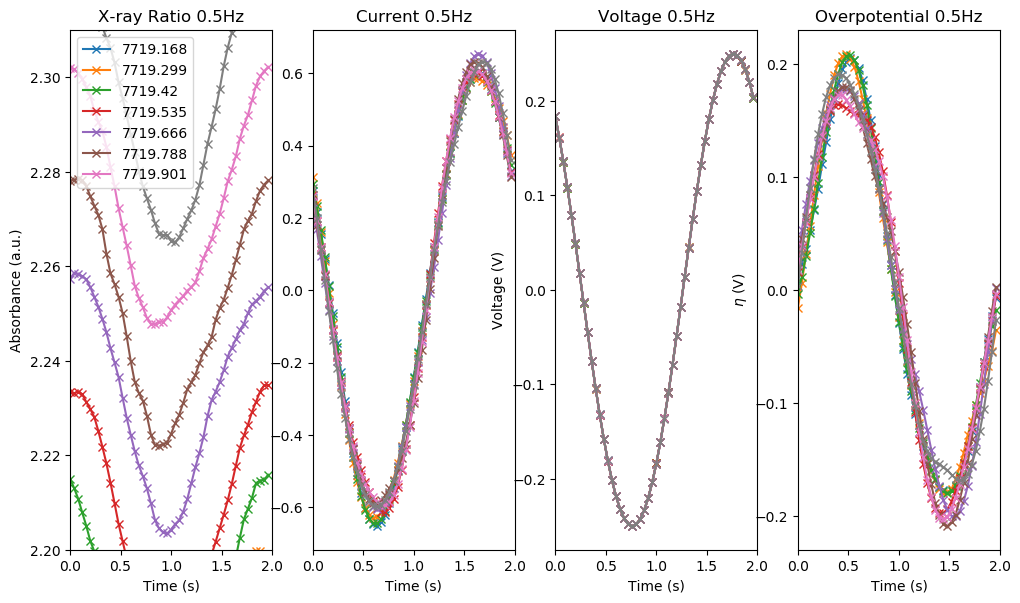

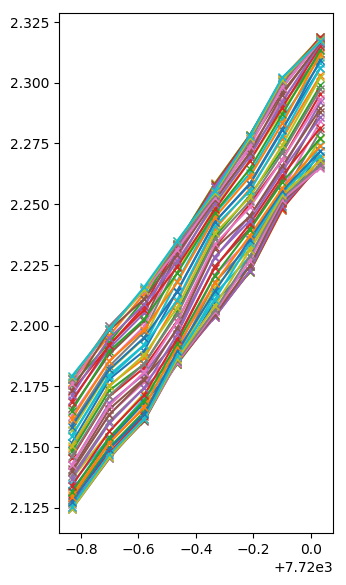

In [98]:
fa=0.5
initfile=82
finfile=89

data=dum1.copy()

path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist=pd.read_csv(path, header=None)
Elist=np.array(Elist[0])

Edum=np.tile(Elist,data.shape[2])
Edum.resize(data.shape[2],Elist.size)

path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List for 5 Hz.txt'

Elist5=pd.read_csv(path, header=None)
Elist5=np.array(Elist5[0])

Edum5=np.tile(Elist5,data.shape[2])
Edum5.resize(data.shape[2],Elist5.size)

fig=plt.figure(figsize=(12,6.75))

ax1=fig.add_subplot(141)
ax1.plot(data[:,0,:].T,data[:,1,:].T,'-x') 
ax1.set_xlim(0,1/fa)
ax1.set_ylim(2.2,2.31)
ax1.set_title('X-ray Ratio '+str(fa)+ 'Hz')
ax1.set_xlabel('Time (s)')
ax1.legend(np.round(Edum[0,initfile:finfile],3),loc='upper left')
ax1.set_ylabel('Absorbance (a.u.)')

ax1=fig.add_subplot(142)
ax1.plot(data[:,0,:].T,data[:,2,:].T,'-x') 
ax1.set_xlim(0,1/fa)
ax1.set_title('Current '+str(fa)+ 'Hz')
ax1.set_xlabel('Time (s)')


ax1=fig.add_subplot(143)
ax1.plot(data[:,0,:].T,data[:,3,:].T,'-x') 
ax1.set_xlim(0,1/fa)
# # ax1.set_ylim(-.0001,.0001)
ax1.set_title('Voltage '+str(fa)+ 'Hz')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')

ax1=fig.add_subplot(144)
ax1.plot(data[:,0,:].T,data[:,6,:].T,'-x') 
ax1.set_xlim(0,1/fa)
# # ax1.set_ylim(-.0001,.0001)
ax1.set_title('Overpotential '+str(fa)+ 'Hz')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(r'$\eta$ (V)')

# plt.show()
# # plt.savefig('0_5 Hz Time Domain Plots.png')

fig2=plt.figure(figsize=(12,6.75))

ax1=fig2.add_subplot(131)
ax1.plot(Edum[:,initfile:finfile+1].T,data[:,1,:],'-x') 
# # ax1.plot(Edum5[::12,:].T,dumdd[:,1,::12],'-x') 
# # ax1.set_xlim(7721,7723)
# # ax1.set_ylim(1.9,2.4)
# ax1.set_title('X-ray Absorption Spectrum '+str(fa)+ 'Hz')
# ax1.set_ylabel('Absorbance (a.u.)')
# ax1.set_xlabel('Energy (eV)')

# ax1=fig.add_subplot(132)
# ax1.plot(Edum5[:,:].T,dum2[:,1,:],'-x') 
# ax1.set_xlim(7705,7730)
# # ax1.set_ylim(1.9,2.4)
# ax1.set_title('X-ray Absorption Spectrum '+str(fa)+ 'Hz')
# ax1.set_xlabel('Energy (eV)')


# ax1=fig.add_subplot(133)
# ax1.plot(Edum5[::12,:].T,dum2[:,1,::12],'-x') 
# ax1.set_xlim(7718,7721)
# # ax1.set_ylim(1.9,2.4)
# ax1.set_title('X-ray Absorption Spectrum '+str(fa)+ 'Hz')
# ax1.set_xlabel('Energy (eV)')
# # ax1.autoscale(enable=True,axis='y',tight=True)
# # ax1.set_ylabel('Absorbance (a.u.)')
# ax1.legend(np.round(np.real(dumdd[0,3,::12]),4))

plt.show()
# plt.savefig('0_5 Hz X-ray Spectra.png')

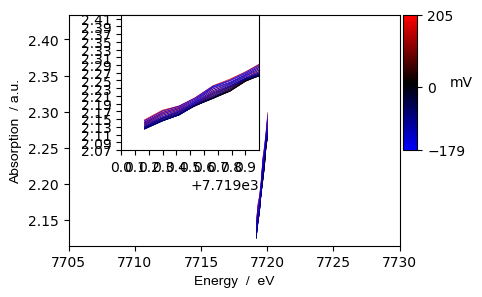

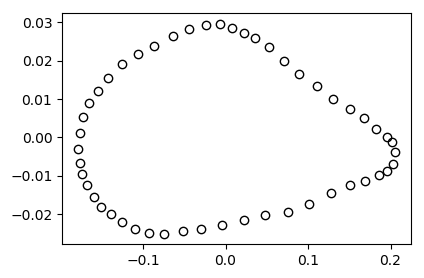

In [113]:
plt0=plotXANES(Edum[:,initfile:finfile+1].T,np.real(data),startE=7705,stopE=7730,startInE=7719,stopInE=7720,
               start=12,stop=12,size=(4.5,3),UseEta=True,marker='')

fig, f_ax1=plt.subplots(ncols=1,nrows=1,figsize=size)

f_ax1.plot(data[0,-1,:],data[0,1,:]-np.mean(data[0,1,:]),'ko',fillstyle='none',label='Data',zorder=3)
plt.show()

In [181]:
np.savetxt('Energy List for 5 Hz.txt', Elistd,fmt='%.8e')

In [46]:
dumdir='Dynamic XAS Energy analyzed data\ESweep_1 Hz'
dumfhead='\Ir_1Hz_ReaddMean_VPhsCorrect_'
SavebyVoltage(np.real(stor),Elist,1,179,dumdir,dumfhead,'.csv')

Dynamic XAS Energy analyzed data\ESweep_1 Hz\Ir_1Hz_ReaddMean_VPhsCorrect_0_16_mV .csv
Dynamic XAS Energy analyzed data\ESweep_1 Hz\Ir_1Hz_ReaddMean_VPhsCorrect_1_47_mV .csv
Dynamic XAS Energy analyzed data\ESweep_1 Hz\Ir_1Hz_ReaddMean_VPhsCorrect_2_77_mV .csv
Dynamic XAS Energy analyzed data\ESweep_1 Hz\Ir_1Hz_ReaddMean_VPhsCorrect_3_106_mV .csv
Dynamic XAS Energy analyzed data\ESweep_1 Hz\Ir_1Hz_ReaddMean_VPhsCorrect_4_133_mV .csv
Dynamic XAS Energy analyzed data\ESweep_1 Hz\Ir_1Hz_ReaddMean_VPhsCorrect_5_158_mV .csv
Dynamic XAS Energy analyzed data\ESweep_1 Hz\Ir_1Hz_ReaddMean_VPhsCorrect_6_181_mV .csv
Dynamic XAS Energy analyzed data\ESweep_1 Hz\Ir_1Hz_ReaddMean_VPhsCorrect_7_201_mV .csv
Dynamic XAS Energy analyzed data\ESweep_1 Hz\Ir_1Hz_ReaddMean_VPhsCorrect_8_217_mV .csv
Dynamic XAS Energy analyzed data\ESweep_1 Hz\Ir_1Hz_ReaddMean_VPhsCorrect_9_231_mV .csv
Dynamic XAS Energy analyzed data\ESweep_1 Hz\Ir_1Hz_ReaddMean_VPhsCorrect_10_240_mV .csv
Dynamic XAS Energy analyzed data\E

C:\Users\shadd\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


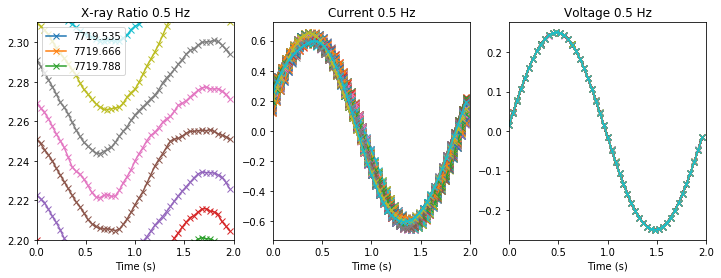

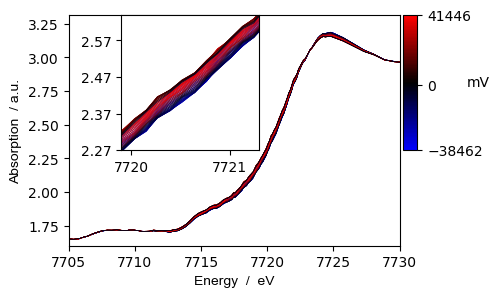

In [84]:
fhead=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy analyzed data'
path1=fhead+r'\ESweep0_5Hz_ReaddMean_VPhsCorrect_RawXray_Dec2000_Hold.txt'

dum1=readolddata(path1,2000,0.5,6)


Irmeans=np.array([np.mean(dum1[:,1,:],axis=1)]).T
dum1[:,1,:]=-1*(dum1[:,1,:]-Irmeans)
dum1[:,1,:]=dum1[:,1,:]+Irmeans

path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist=pd.read_csv(path, header=None)
Elist=np.array(Elist[0])

Edum=np.tile(Elist,dum1.shape[2])
Edum.resize(dum1.shape[2],Elist.size)
Edum=Edum.transpose()


fig=plt.figure(figsize=(12,4))
mpl.style.use('default')
# sns.set_palette(default')

ax1=fig.add_subplot(131)
ax1.plot(dum1[:,0,:].T,dum1[:,1,:].T,'-x') 
ax1.set_xlim(0,2)
ax1.set_ylim(2.2,2.31)
ax1.set_title('X-ray Ratio 0.5 Hz')
ax1.set_xlabel('Time (s)')
ax1.legend(np.round(Edum[85:88,0],3),loc='upper left')
# ax1.set_ylabel('Absorbance (a.u.)')

ax1=fig.add_subplot(132)
ax1.plot(dum1[:,0,:].T,dum1[:,2,:].T,'-x') 
ax1.set_xlim(0,2)
ax1.set_title('Current 0.5 Hz')
ax1.set_xlabel('Time (s)')
# ax1.set_ylabel('Voltage (V)')

ax1=fig.add_subplot(133)
ax1.plot(dum1[:,0,:].T,dum1[:,3,:].T,'-x') 
ax1.set_xlim(0,2)
# ax1.set_ylim(-.0001,.0001)
ax1.set_title('Voltage 0.5 Hz')
ax1.set_xlabel('Time (s)')
# ax1.legend(dum1[:,3,0],loc='upper left')
# ax1.set_ylabel('Voltage (V)')

plt.show()
# plt.savefig('0_5 Hz Time Domain Plots Voltage Phs.png')

plt0=plotXANES(Edum,np.real(dum1),startE=7705,stopE=7730,startInE=7720,stopInE=7721.5,
               start=0,stop=0,in_adjs=[0,-.6,1,.05,-.18,.1,-.1,0],size=(4.5,3),UseEta=True,marker='')
# plt0.savefig('0_5 Hz X-ray Spectra Voltage Phs.png',bbox_inches='tight',dpi=500)
# plt.savefig('0_5 Hz X-ray Spectra Voltage Phs.png',format='png')

In [9]:
fhead=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy analyzed data'
path1=fhead+r'\ESweep0_5Hz_ReaddMean_VPhsCorrect_RawXray_Dec2000_Hold.txt'
path2=fhead+r'\ESweep1Hz_ReaddMean_VPhsCorrect_RawXray_Dec1000_Hold.txt'
path3=fhead+'\ESweep5Hz_ReaddMean_VPhsCorrect_RawXray_Dec200_Hold.txt'

dum1=readolddata(path1,2000,0.5,6)
Irmeans=np.array([np.mean(dum1[:,1,:],axis=1)]).T
dum1[:,1,:]=-1*(dum1[:,1,:]-Irmeans)
dum1[:,1,:]=dum1[:,1,:]+Irmeans

dum2=readolddata(path2,1000,1,6)
Irmeans=np.array([np.mean(dum2[:,1,:],axis=1)]).T
dum2[:,1,:]=-1*(dum2[:,1,:]-Irmeans)
dum2[:,1,:]=dum2[:,1,:]+Irmeans

dum3=readolddata(path3,200,5,6)
Irmeans=np.array([np.mean(dum3[:,1,:],axis=1)]).T
dum3[:,1,:]=-1*(dum3[:,1,:]-Irmeans)
dum3[:,1,:]=dum3[:,1,:]+Irmeans


dum1=CalcEta(dum1)
dum2=CalcEta(dum2)
dum3=CalcEta(dum3)

Abs1=dum1[89,1,:].T-np.mean(dum1[89,1,:])
Abs2=dum2[89,1,:].T-np.mean(dum2[89,1,:])
Abs3=dum3[89,1,:].T-np.mean(dum3[89,1,:])

Eta1=1000*dum1[89,6,:].T
Eta2=1000*dum2[89,6,:].T
Eta3=1000*dum3[89,6,:].T
size=(4.5,3)

V=dum1[0,3,:,None].T
I=dum1[0,2,:,None].T
#     eta=np.real(V)*np.abs(R2/(R1*(1+(2*np.pi*freq*1j*Q)**a*R2)+R2))
Rohm=63.97
eta=V-I*Rohm/100


# fig2, f2_ax1=plt.subplots(ncols=1,nrows=1,figsize=size)

# f2_ax1.plot(Eta1[:],Abs1[:],'-x',color='0.6',zorder=2,label='0.5 Hz')
# f2_ax1.plot(Eta2[:],Abs2[:],'-d',color='0.3',zorder=3,label='1 Hz')
# f2_ax1.plot(Eta3,Abs3,'.',color='0',zorder=4,label='5 Hz')

# f2_ax1.set(xlabel='Overpotential \ mV', ylabel=r'Absorbance at 7720 eV \ a.u.',
#           xticks=np.arange(-100,101,50))
# ax1minLoc=mpl.ticker.MultipleLocator(25)
# f2_ax1.xaxis.set_minor_locator(ax1minLoc)
# f2_ax1.legend(frameon=False,shadow=False)

# fig2.savefig('7720 eV Abs vs Eta Indiv Phase.png',bbox_inches='tight',dpi=500)

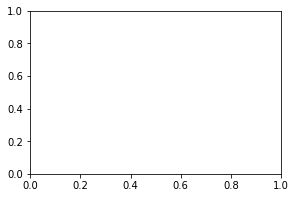

In [48]:
 fig2, f2_ax1=plt.subplots(ncols=1,nrows=1,figsize=size)
dum1=dum2.copy()

V=dum1[:,3,:]
I=dum1[:,2,:]
#     eta=np.real(V)*np.abs(R2/(R1*(1+(2*np.pi*freq*1j*Q)**a*R2)+R2))
Rohm=63.97
eta=V-I*Rohm/100
# eta=np.transpose(eta,(0,2,1))
# dum1=np.concatenate((dum1,eta),axis=1)


# f2_ax1.plot(dum1[:,0,:].T, dum1[:,7,:].T,'x-')
# f2_ax1.plot(dum1[90,0,:,None],dum1[90,1,:,None]-np.mean(dum1[90,1,:,None]),'d-')
# f2_ax1.plot(dum1[:,0,:].T,np.transpose(dum1[:,2,:]-np.mean(dum1[:,2,:])),'s-')
# f2_ax1.plot(dum1[90,0,:,None],dum1[90,3,:,None]-np.mean(dum1[90,3,:,None]),'^-')
plt.show()

In [70]:
dum2=np.delete(dum2,74,axis=0)

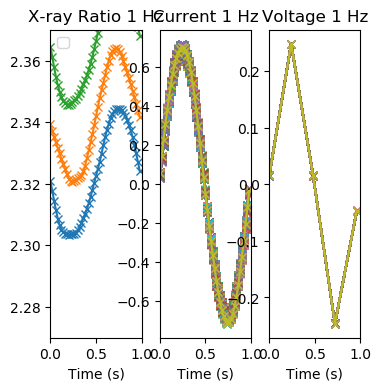

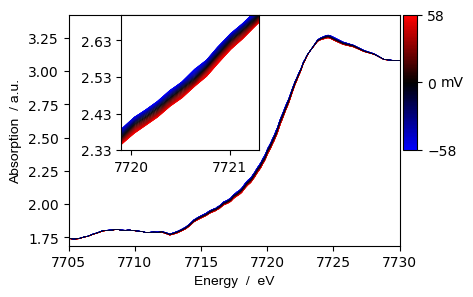

In [12]:
fhead=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy analyzed data'
path2=fhead+r'\ESweep1Hz_ReaddMean_PhsCorrect_RawXray_Dec1000.txt'

dum2=readolddata(path2,1000,1,NumCh=6)

Irmeans=np.array([np.mean(dum2[:,1,:],axis=1)]).T
dum2[:,1,:]=-1*(dum2[:,1,:]-Irmeans)
dum2[:,1,:]=dum2[:,1,:]+Irmeans

path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist=pd.read_csv(path, header=None)
Elist=np.array(Elist[0])

Edum=np.tile(Elist,dum2.shape[2])
Edum.resize(dum2.shape[2],Elist.size)
Edum=Edum.transpose()

## Removing weird values ~7718.2 eV from data set
dum2=np.delete(dum2,74,axis=0)
Edum=np.delete(Edum,74,axis=0)

fig=plt.figure(figsize=(4,4))

ax1=fig.add_subplot(131)
ax1.plot(dum2[85:88,0,:].T,dum2[85:88,1,:].T,'-x') 
ax1.set_xlim(0,1)
ax1.set_ylim(2.27,2.37)
ax1.set_title('X-ray Ratio 1 Hz')
ax1.set_xlabel('Time (s)')
ax1.legend(np.round(Edum[0,85:88],3),loc='upper left')
# ax1.set_ylabel('Absorbance (a.u.)')

ax1=fig.add_subplot(132)
ax1.plot(dum2[:,0,:].T,dum2[:,2,:].T,'-x') 
ax1.set_xlim(0,1)
ax1.set_title('Current 1 Hz')
ax1.set_xlabel('Time (s)')
# ax1.set_ylabel('Voltage (V)')

ax1=fig.add_subplot(133)
ax1.plot(dum2[:,0,::12].T,dum2[:,3,::12].T,'-x') 
ax1.set_xlim(0,1)
# ax1.set_ylim(-.0001,.0001)
ax1.set_title('Voltage 1 Hz')
ax1.set_xlabel('Time (s)')
# ax1.set_ylabel('Voltage (V)')

# plt.show()
# plt.savefig('1 Hz Time Domain Plots.png')
plt1=plotXANES(Edum,np.real(dum2),startE=7705,stopE=7730,startInE=7720,stopInE=7721.5,
               start=0,stop=0,in_adjs=[0,-.6,1,.05,-.18,.1,-.1,0],size=(4.5,3),UseEta=True,marker='')
# plt1.savefig('1 Hz X-ray Spectra Phs.png',dpi=500, bbox_inches='tight')


In [73]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist5=pd.read_csv(path, header=None)
Elist5=np.array(Elist5[0])
Elist5=np.delete(Elist5,6)
Elist5=np.delete(Elist5,0)

In [16]:
dum3[6,:,:4]

array([[ 0.00000000e+00+0.00000000e+00j,  4.00000000e-03+0.00000000e+00j,
         8.00000000e-03+0.00000000e+00j,  1.20000000e-02+0.00000000e+00j],
       [ 1.76169509e+00-4.47829399e-16j,  1.76172790e+00-4.47827898e-16j,
         1.76173925e+00-4.47828484e-16j,  1.76175210e+00-4.47826049e-16j],
       [-8.33921040e-04-2.16521675e-15j, -7.69084962e-04-2.16515959e-15j,
        -6.69892112e-04-2.16523199e-15j, -6.12194249e-04-2.16521010e-15j],
       [-6.62940386e-07-9.86777001e-18j,  4.05725323e-06-9.86769937e-18j,
         3.16438433e-05-9.86784593e-18j,  3.05729226e-06-9.86793431e-18j],
       [ 7.55841822e-02-1.11929983e-14j,  7.55824425e-02-1.11929981e-14j,
         7.55818951e-02-1.11929985e-14j,  7.55815619e-02-1.11929983e-14j],
       [ 1.33153708e-01-1.02561575e-14j,  1.33153143e-01-1.02561569e-14j,
         1.33153044e-01-1.02561578e-14j,  1.33153440e-01-1.02561573e-14j]])

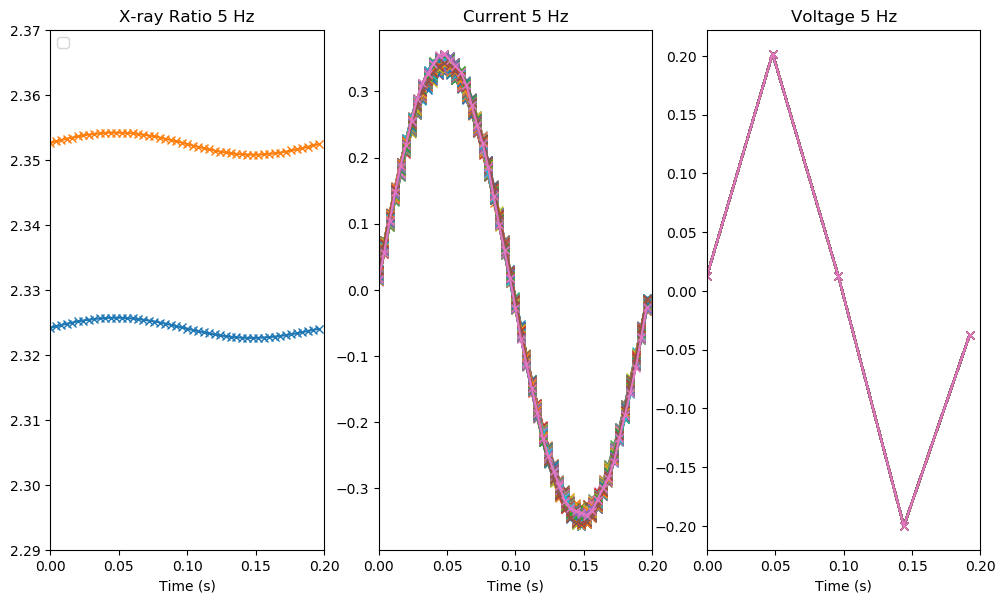

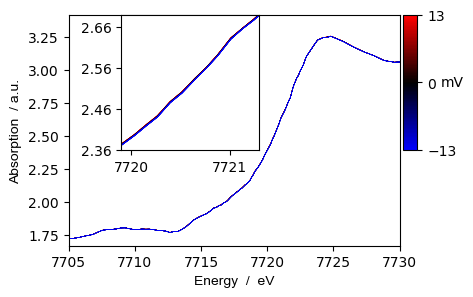

In [26]:
fhead=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy analyzed data'
path3=fhead+'\ESweep5Hz_ReaddMean_PhsCorrect_RawXray_Dec200_Hold.txt'

dum3=readolddata(path3,200,5,6)

# Irmeans=np.array([np.mean(dum3[:,1,:],axis=1)]).T
# dum3[:,1,:]=-1*(dum3[:,1,:]-Irmeans)
# dum3[:,1,:]=dum3[:,1,:]+Irmeans

path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist5=pd.read_csv(path, header=None)
Elist5=np.array(Elist5[0])
Elist5=np.delete(Elist5,158)
Elist5=np.delete(Elist5,106)
Elist5=np.delete(Elist5,6)

dum3=np.delete(dum3,6,axis=0)


Edum5=np.tile(Elist5,dum3.shape[2])
Edum5.resize(dum3.shape[2],Elist5.size)
Edum5=Edum5.transpose()

fig=plt.figure(figsize=(12,6.75))

ax1=fig.add_subplot(131)
ax1.plot(dum3[85:88,0,:].T,dum3[85:88,1,:].T,'-x') 
ax1.set_xlim(0,.2)
ax1.set_ylim(2.29,2.37)
ax1.set_title('X-ray Ratio 5 Hz')
ax1.set_xlabel('Time (s)')
ax1.legend(Edum5[0,85:88],loc='upper left')
# ax1.set_ylabel('Absorbance (a.u.)')

ax1=fig.add_subplot(132)
ax1.plot(dum3[:,0,:].T,dum3[:,2,:].T,'-x') 
ax1.set_xlim(0,.2)
ax1.set_title('Current 5 Hz')
ax1.set_xlabel('Time (s)')
# ax1.set_ylabel('Voltage (V)')

ax1=fig.add_subplot(133)
ax1.plot(dum3[:,0,::12].T,dum3[:,3,::12].T,'-x') 
ax1.set_xlim(0,.2)
# ax1.set_ylim(-.0001,.0001)
ax1.set_title('Voltage 5 Hz')
ax1.set_xlabel('Time (s)')
# ax1.set_ylabel('Voltage (V)')

# plt.show()
# plt.savefig('5 Hz Time Domain Plots.png')

plt2=plotXANES(Edum5,np.real(dum3),startE=7705,stopE=7730,startInE=7720,stopInE=7721.5,
               start=12,stop=12,in_adjs=[0,-.6,1,.08,-.18,.1,-.1,0],size=(4.5,3),UseEta=True,marker='')
# plt2.tight_layout()
# plt2.savefig('5 Hz X-ray Spectra Voltage Phs.png',dpi=500, bbox_inches='tight')

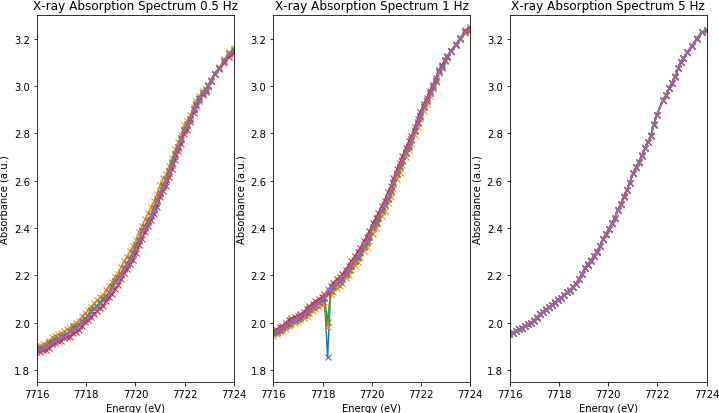

In [258]:
fig=plt.figure(figsize=(12,6.75))

ax1=fig.add_subplot(131)
ax1.plot(Edum[::12,:].T,dum1[:,1,::12],'-x') 
ax1.set_xlim(7716,7724)
ax1.set_ylim(1.75,3.3)
ax1.set_title('X-ray Absorption Spectrum 0.5 Hz')
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Absorbance (a.u.)')

ax1=fig.add_subplot(132)
ax1.plot(Edum[::12,:].T,dum2[:,1,::12],'-x') 
ax1.set_xlim(7716,7724)
ax1.set_ylim(1.75,3.3)
ax1.set_title('X-ray Absorption Spectrum 1 Hz')
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Absorbance (a.u.)')

ax1=fig.add_subplot(133)
ax1.plot(Edum5[::12,:].T,dum3[:,1,::12],'-x') 
ax1.set_xlim(7716,7724)
ax1.set_ylim(1.75,3.3)
ax1.set_title('X-ray Absorption Spectrum 5 Hz')
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Absorbance (a.u.)')


plt.savefig('X-ray edge comparison.png')

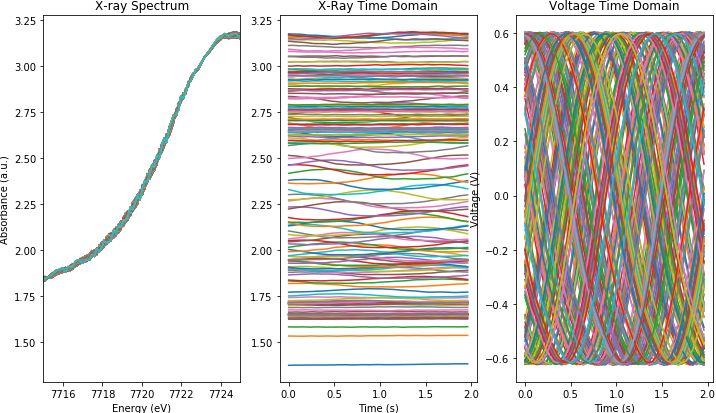

In [250]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy analyzed data\ESweep0_5Hz_NoPhsCorrectNoSub.txt'

dum1=readolddata(path,2000,0.5)


path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist=pd.read_csv(path, header=None)
Elist=np.array(Elist[0])

Edum=np.tile(Elist,dum1.shape[2])
Edum.resize(dum1.shape[2],Elist.size)

mpl.rcParams['savefig.pad_inches']=0

fig=plt.figure(figsize=(12,6.75))


ax1=fig.add_subplot(131)
ax1.plot(Edum[:,:].T,dum1[:,1,:],'-') 
ax1.set_xlim(7715,7725)
ax1.set_title('X-ray Spectrum')
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Absorbance (a.u.)')

ax1=fig.add_subplot(132)
ax1.plot(dum1[:,0,:].T,dum1[:,1,:].T,'-')
ax1.set_title('X-Ray Time Domain')
ax1.set_xlabel('Time (s)')

ax1=fig.add_subplot(133)
ax1.plot(dum1[:,0,:].T,dum1[:,3,:].T,'-')
ax1.set_title('Voltage Time Domain')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')


# plt.show()

plt.savefig('0_5 Hz No Phs Correct No Sub Mean.png') 

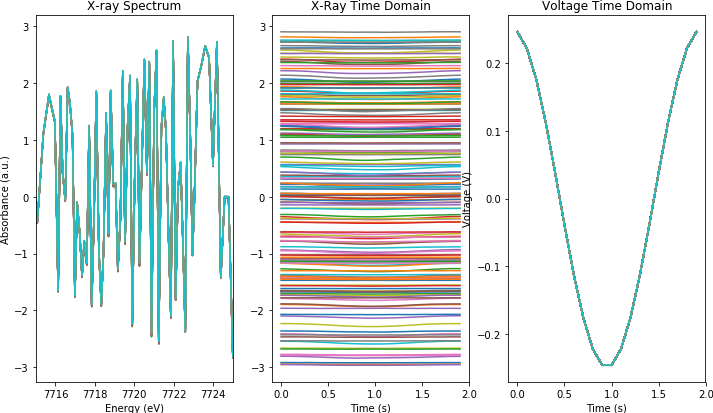

In [253]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy analyzed data\ESweep0_5Hz_NoSub.txt'

dum1=readolddata(path,5000,0.5)


path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist=pd.read_csv(path, header=None)
Elist=np.array(Elist[0])

Edum=np.tile(Elist,dum1.shape[2])
Edum.resize(dum1.shape[2],Elist.size)

fig=plt.figure(figsize=(12,6.75))

ax1=fig.add_subplot(131)
ax1.plot(Edum[:,:].T,dum1[:,1,:],'-') 
ax1.set_xlim(7715,7725)
ax1.set_title('X-ray Spectrum')
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Absorbance (a.u.)')

ax1=fig.add_subplot(132)
ax1.plot(dum1[:,0,:].T,dum1[:,1,:].T,'-')
ax1.set_title('X-Ray Time Domain')
ax1.set_xlabel('Time (s)')

ax1=fig.add_subplot(133)
ax1.plot(dum1[:,0,:].T,dum1[:,3,:].T,'-')
ax1.set_title('Voltage Time Domain')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')

# plt.show()

plt.savefig('0_5 Hz Phs Correct No Sub Mean.png') 

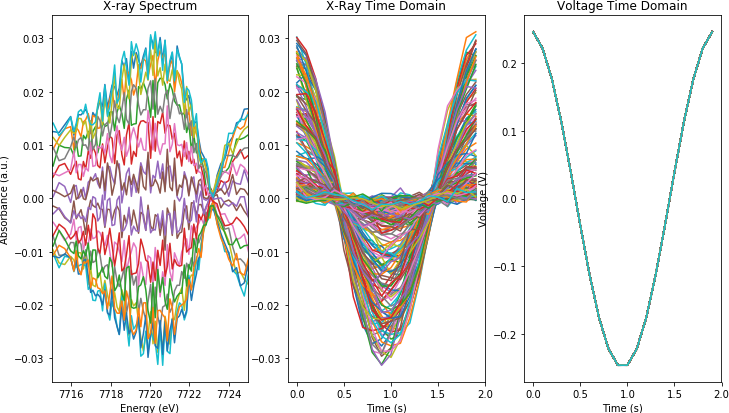

In [254]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy analyzed data\ESweep0_5Hz_Subtracted Means.txt'

dum1=readolddata(path,5000,0.5)


path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist=pd.read_csv(path, header=None)
Elist=np.array(Elist[0])

Edum=np.tile(Elist,dum1.shape[2])
Edum.resize(dum1.shape[2],Elist.size)

fig=plt.figure(figsize=(12,6.75))


ax1=fig.add_subplot(131)
ax1.plot(Edum[:,:].T,dum1[:,1,:],'-') 
ax1.set_xlim(7715,7725)
ax1.set_title('X-ray Spectrum')
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Absorbance (a.u.)')

ax1=fig.add_subplot(132)
ax1.plot(dum1[:,0,:].T,dum1[:,1,:].T,'-')
ax1.set_title('X-Ray Time Domain')
ax1.set_xlabel('Time (s)')

ax1=fig.add_subplot(133)
ax1.plot(dum1[:,0,:].T,dum1[:,3,:].T,'-')
ax1.set_title('Voltage Time Domain')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')

# plt.show()

plt.savefig('0_5 Hz Phs Correct Sub Mean.png') 

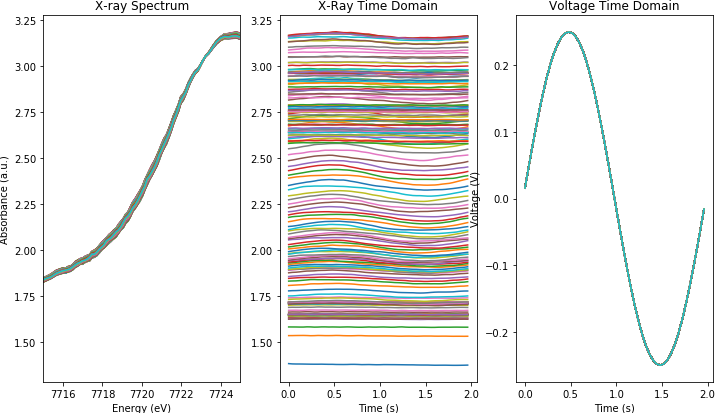

In [255]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy analyzed data\ESweep0_5Hz_ReaddMean_PhsCorrect_Dec2000.txt'

dum1=readolddata(path,2000,0.5)


path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist=pd.read_csv(path, header=None)
Elist=np.array(Elist[0])

Edum=np.tile(Elist,dum1.shape[2])
Edum.resize(dum1.shape[2],Elist.size)

fig=plt.figure(figsize=(12,6.75))


ax1=fig.add_subplot(131)
ax1.plot(Edum[:,:].T,dum1[:,1,:],'-') 
ax1.set_xlim(7715,7725)
ax1.set_title('X-ray Spectrum')
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Absorbance (a.u.)')

ax1=fig.add_subplot(132)
ax1.plot(dum1[:,0,:].T,dum1[:,1,:].T,'-')
ax1.set_title('X-Ray Time Domain')
ax1.set_xlabel('Time (s)')

ax1=fig.add_subplot(133)
ax1.plot(dum1[:,0,:].T,dum1[:,3,:].T,'-')
ax1.set_title('Voltage Time Domain')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')

# plt.show()

plt.savefig('0_5 Hz Phs Correct Readd Mean.png') 

In [43]:
del data, dum2d, dum3d, dum1

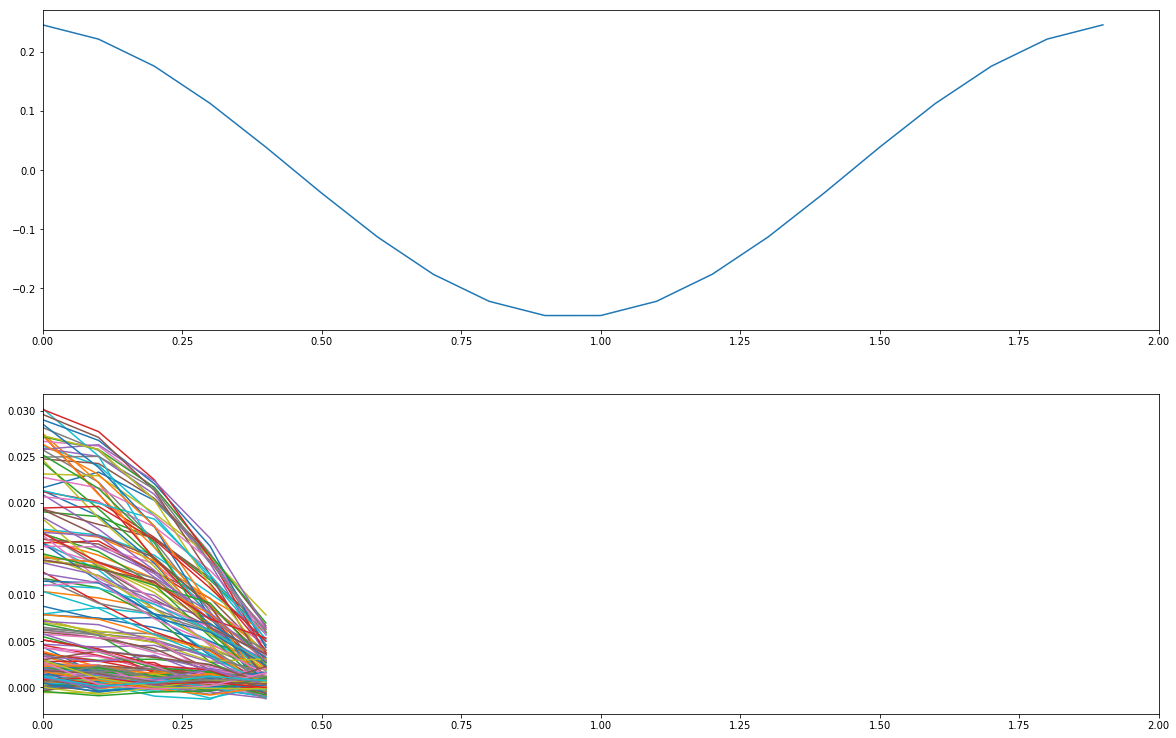

In [38]:
fig=plt.figure(figsize=(20,20))

ax1=fig.add_subplot(311)
ax1.plot(np.real(dum1[0,0,:]),dum1[85,3,:])
ax1.set_xlim(0,2)

ax1=fig.add_subplot(312)
ax1.plot(np.real(dum1[:,0,0:5].T),dum1[:,1,0:5].T)
ax1.set_xlim(0,2)

plt.show()

In [110]:
#Reads data without doing any phase corrections or signal averaging/decimating

path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data'
initfile=80
finfile=80
filea=np.r_[initfile:finfile+1]
for n in filea:
    filestr=str(path+'/E'+str(n)+'.txt')
    print(filestr)
    all_files=glob.glob(filestr)
    data=pd.read_csv(filestr,delimiter='\t', header=None,engine='python')
    data.columns=('Time','Io','If','J','V') #Io is incident X-ray, If is fluroesced X-ray
    if n==filea[0]:
        print('first')
#         dum1=fullanalyze(data, 0.5,2000)
        dum1=np.array(data,ndmin=3)
    else:
        print(n)    
#         dum1=np.concatenate((dum1,fullanalyze(data,0.5,2000)),axis=0)
        dum1=dum1=np.concatenate((dum1,np.array(data,ndmin=3)),axis=0).transpose(0,2,1)

C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E80.txt
first


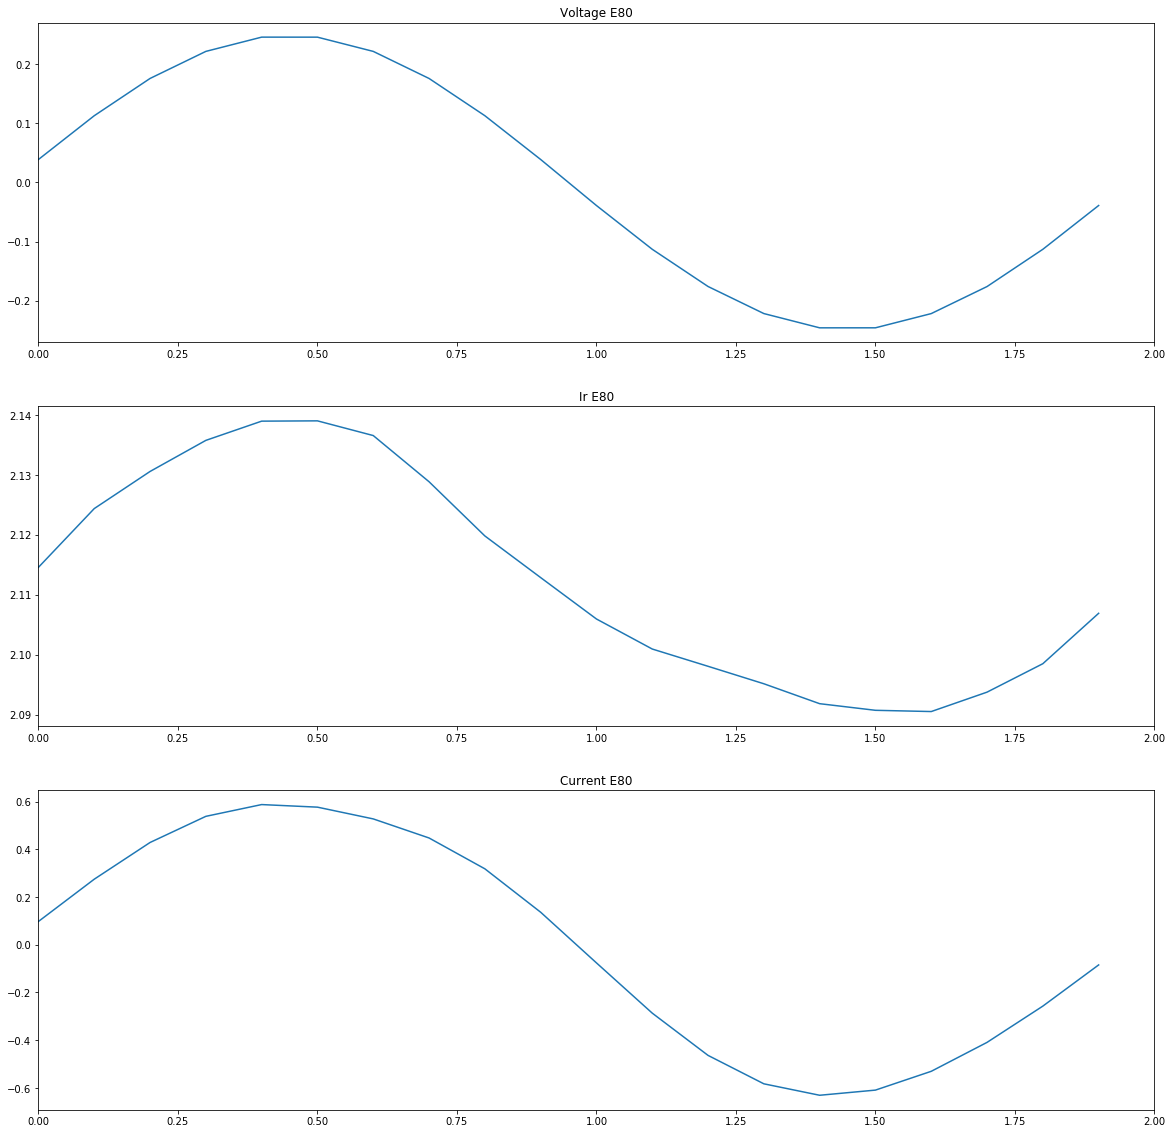

In [112]:
fig=plt.figure(figsize=(20,20))

ax1=fig.add_subplot(311)
ax1.plot(datav[0,0,:],datav[0,3,:])
ax1.set_title(str('Voltage E'+str(initfile)))
ax1.set_xlim(0,2)

ax1=fig.add_subplot(312)
ax1.plot(datav[0,0,:],datav[0,1,:])
ax1.set_title(str('Ir E'+str(initfile)))
ax1.set_xlim(0,2)

ax1=fig.add_subplot(313)
ax1.plot(datav[0,0,:],datav[0,2,:])
ax1.set_title(str('Current E'+str(initfile)))
ax1.set_xlim(0,2)

plt.show()

In [114]:
fig.savefig('Dynamic XAS Energy Plots\E'+ str(initfile)+'plots Readd Mean With Phs Corr.png')

# Old code below. Probably still works-- mostly process of figuring out the fullanalyze function

In [3]:
#path=r'G:/My Drive/UW Research/Dynamic XAS Data/Energy Spectrum_0.5Hz/Txt Files/E85.txt'
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data\E85.txt'
all_files=glob.glob(path)
data=pd.read_csv(path,delimiter='\t', header=None)
data.columns=('Time','Io','If','J','V') #Io is incident X-ray, If is fluroesced X-ray

Ir=np.array(data['If']/data['Io'])
datan=np.array([data['Time'],submean(Ir),submean(data['J']),submean(data['V'])])

Ns=datan[0,:].size
dt=datan[0,1]

In [4]:
datafft, freq=getfft(datan[1:,:],datan[0,:])

In [5]:
fftang=np.angle(datafft)
fftmag=np.abs(datafft)
bin1=datain.fftbin(0.5,freq,Ns,dt,"Real",1)
angadj=fftang[0,int(bin1[1])]+np.pi/2
angadj2=fftang[1,int(bin1[1])]+np.pi/2
angadj3=fftang[2,int(bin1[1])]+np.pi/2

fftang2=fftang

fftang2[0,int(Ns/2):]=fftang[0,int(Ns/2):]-angadj #adjusting positive frequencies
fftang2[0,:int(Ns/2)]=fftang[0,:int(Ns/2)]+angadj #adjusting negative frequencies

fftang2[1,int(Ns/2):]=fftang[1,int(Ns/2):]-angadj2 #adjusting positive frequencies
fftang2[1,:int(Ns/2)]=fftang[1,:int(Ns/2)]+angadj2 #adjusting negative frequencies

fftang2[2,int(Ns/2):]=fftang[2,int(Ns/2):]-angadj3 #adjusting positive frequencies
fftang2[2,:int(Ns/2)]=fftang[2,:int(Ns/2)]+angadj3 #adjusting negative frequencies

datafft2=datain.P2R(fftmag,fftang2)

In [6]:
print(np.shape(fftang))
print(np.angle(datafft[2,int(bin1[0])+1]),np.angle(datafft[2,int(bin1[1])]))
print(freq[int(bin1[1]):int(bin1[1])+3])
print(freq[int(bin1[0])-1:int(bin1[0])+3])
print(angadj,np.angle(datafft2[1,int(bin1[0])]))
print(fftang[2,int(bin1[1])+4],fftang2[2,int(bin1[1])+4])

(3, 3000000)
-0.9424556956177024 0.9424556956177024
[0.5        0.51666667 0.53333333]
[-0.53333333 -0.51666667 -0.5        -0.48333333]
2.513252022412599 -1.714993984058784
-1.629210258963357 -1.629210258963357


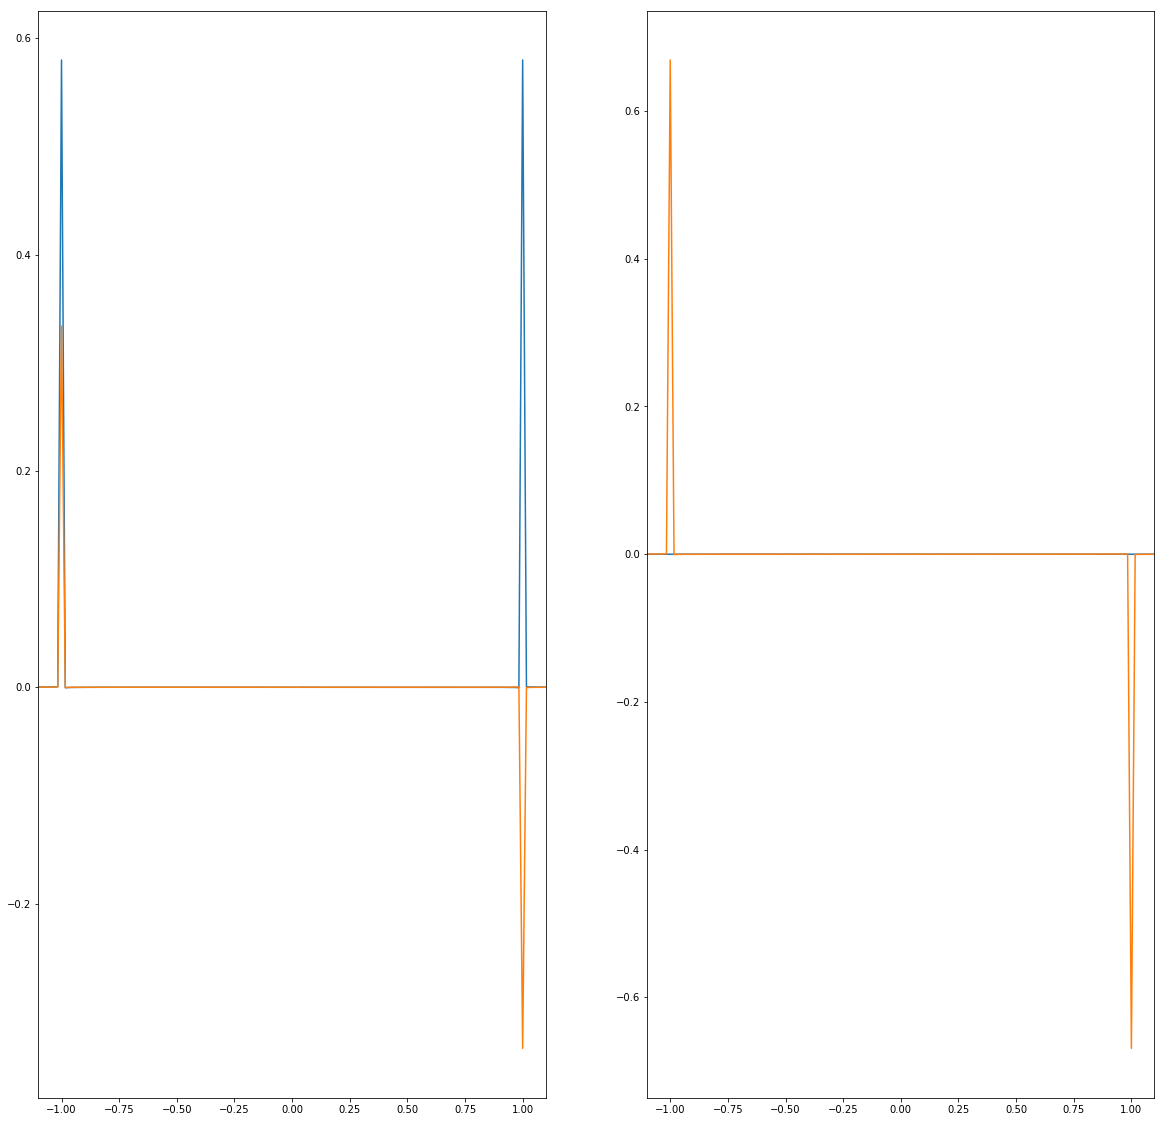

In [18]:
fig=plt.figure(figsize=(20,20))
ax1=fig.add_subplot(121)

ax1.plot(freq,np.real(datafft[2,:]),freq,np.imag(datafft[2,:]))
ax1.set_xlim(-1.1,1.1)

ax1=fig.add_subplot(122)

ax1.plot(freq,np.real(datafft2[2,:]),freq,np.imag(datafft2[2,:]))
ax1.set_xlim(-1.1,1.1)
# ax1.set_ylim(0,.001)
plt.show()

In [6]:
dataffti=np.fft.ifft(np.fft.ifftshift(datafft2)*Ns/2)

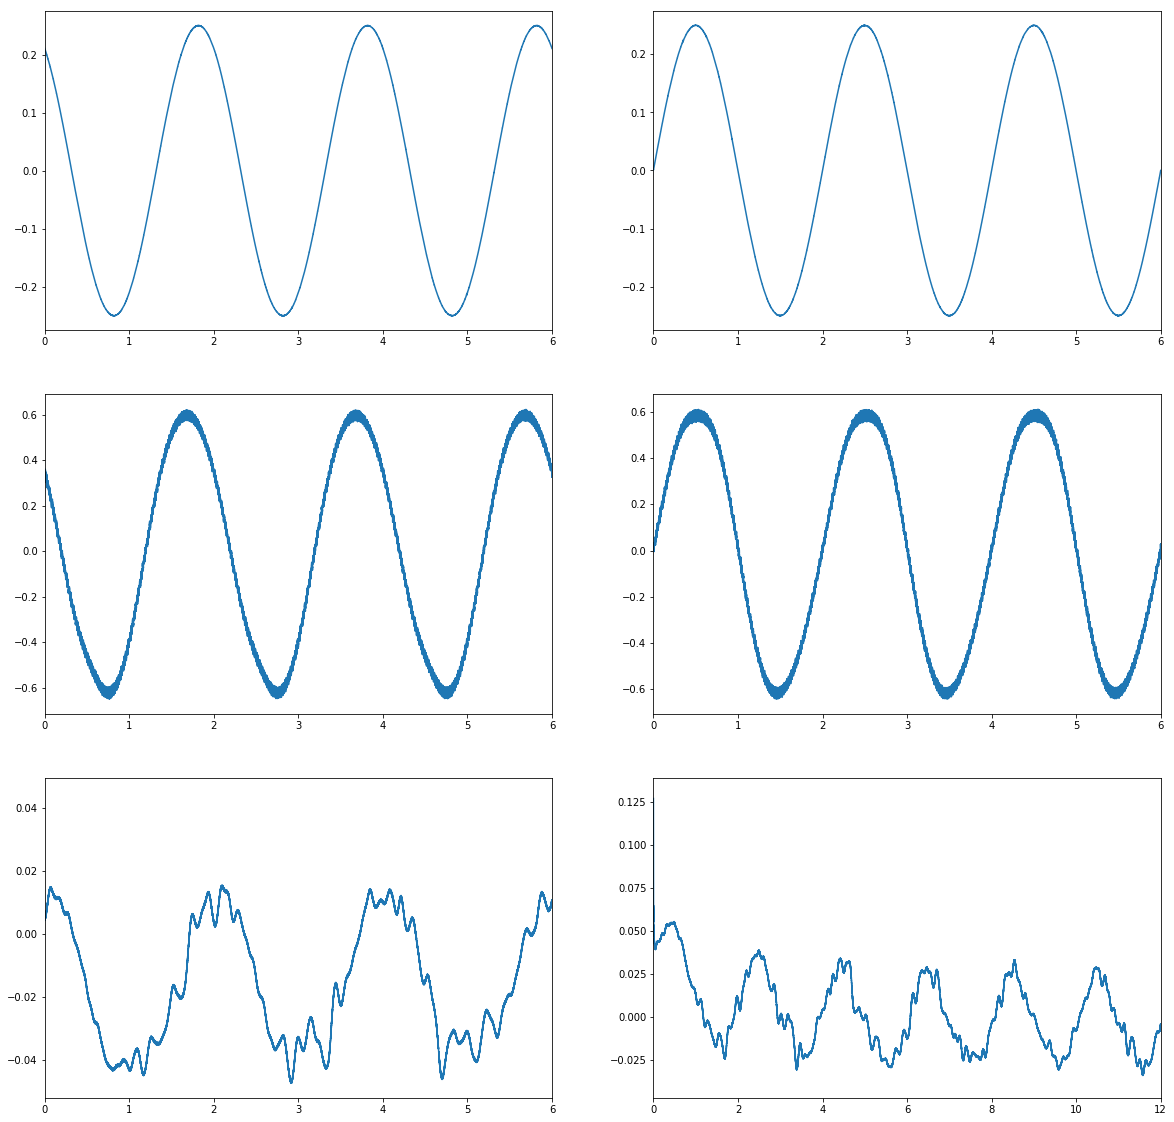

In [8]:
fig=plt.figure(figsize=(20,20))

ax1=fig.add_subplot(321)
ax1.plot(datan[0,:],datan[3,:])
ax1.set_xlim(0,6)

ax1=fig.add_subplot(322)
ax1.plot(datan[0,:],dataffti[2,:])
ax1.set_xlim(0,6)

ax1=fig.add_subplot(323)
ax1.plot(datan[0,:],datan[2,:])
ax1.set_xlim(0,6)

ax1=fig.add_subplot(324)
ax1.plot(datan[0,:],dataffti[1,:])
ax1.set_xlim(0,6)

ax1=fig.add_subplot(325)
ax1.plot(datan[0,:],datan[1,:])
ax1.set_xlim(0,6)

ax1=fig.add_subplot(326)
ax1.plot(datan[0,:],dataffti[0,:])
ax1.set_xlim(0,6)

plt.show()

In [10]:
t=datan[0,:]
Ir=dataffti[0,:]
V=dataffti[1,:]
J=dataffti[2,:]

In [13]:
fa=0.5
dec=2000
fs=50000

Irdec,tdec=decimate(Ir,tarr=t,decfac=dec)
Iav,tav=sigavg(Irdec, freq=fa,tarr=tdec,sampf=fs/dec,decfac=dec)
Vav=sigavg(decimate(V,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)
Jav=sigavg(decimate(J,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)

Iav=Iav-np.mean(Iav)
Vav=Vav-np.mean(Vav)
Jav=Jav-np.mean(Jav)

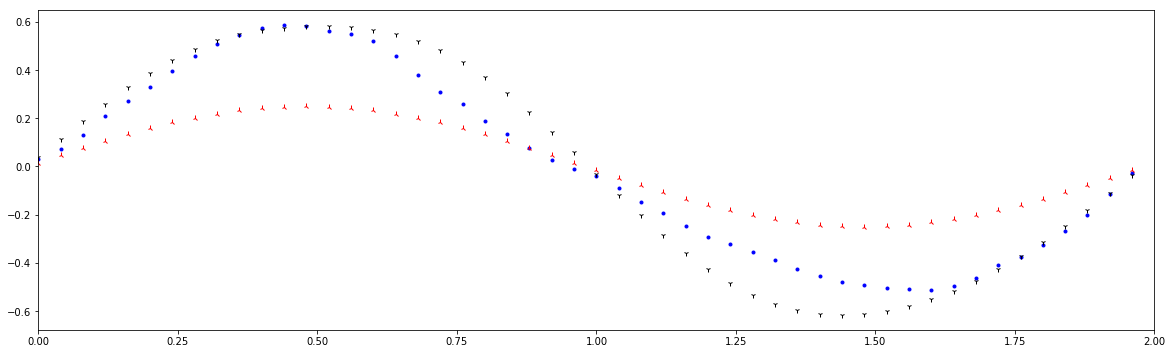

In [14]:
fig=plt.figure(figsize=(20,20))

# ax1=fig.add_subplot(311)
# ax1.plot(tdec,Idec1,'b.',tdec,Idec2,'k1',tdec,Idec3,'r2', tav,Iav,'g3')
# ax1.set_xlim(0,4)

# ax1=fig.add_subplot(312)
# ax1.plot(tdec,Idiff1,'b.',tdec,Idiff2,'k1',tdec,Idiff3,'r2')
# ax1.set_xlim(0,4)

ax1=fig.add_subplot(313)
ax1.plot(tav,(Iav)*20,'b.',tav,Vav,'k1',tav,Jav,'r2')
ax1.set_xlim(0,2)

plt.show()

In [8]:
decfac=500
Idec1,tdec=decimate(Ir,t,500)
Idec2=signal.resample(Ir,int(len(Ir)/decfac))
Idec3=signal.decimate(signal.decimate(signal.decimate(Ir,10),10),5)

Idiff1=np.sqrt((Idec2-Idec1)**2)
Idiff2=np.sqrt((Idec3-Idec1)**2)
Idiff3=np.sqrt((Idec3-Idec2)**2)
print(Idec1.shape,Idec2.shape,Idec3.shape,tdec.shape)
print(Idiff1.shape,Idiff2.shape,Idiff3.shape)

(6000,) (6000,) (6000,) (6000,)
(6000,) (6000,) (6000,)


In [ ]:
np.save